In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Self-Avoiding Walks
Self-avoiding walks (SAW) are simply random walks in a regular lattice with the additional constraint that no point can be visited more than once. That is, SAW cannot intersect themselves. The most well-known application of SAW is to model linear polymers, where obviously two monomers cannot occupy the same space (excluded volume effect).


You can read more about self-avoiding walks in this nice introduction by Gordon Slade:

[Self-Avoiding Walks, by Gordon Slade](https://www.math.ubc.ca/~slade/intelligencer.pdf)

## Simulating Self-Avoiding Walks
Generating a SAW is not trivial. If you try to generate a SAW stochastically, that is, one step at a time, you will miserably fail: your walker might get into traps (configurations with no allowed movements), and if it does you will have to discard your simulation. It turns out you will have to discard your simulation *really* often, so that for large lengths, you will basically never find a valid path. In addition, the paths you will find for short lengths will not come up with the right probabilities. Bear in mind that we want to **uniformly sample** the set of SAW of given length $n$, SAW($n$). That is, we want that all paths from SAW($n$) are generated with the same probability.

The solution is to use a Monte Carlo algorithm that, given one element $\alpha \in \text{SAW}(n)$, generates a new one $\beta \in \text{SAW}(n)$ with some probability $P_{\alpha \beta}$. If in addition our algorithm satisfies **detailed balance** and is **ergodic**, then we known that it will converge to the equilibrium distribution (the uniform distribution in our case).


## The pivot algorithm
We will implement the pivot algorithm, which is simple, effective, and satisfies detailed balance and ergodicity. You can read about the details of the pivot algorithm here:

[The Pivot Algorithm: A Highly Efficient Monte Carlo Method for the Self-Avoiding Walk](https://link.springer.com/article/10.1007/BF01022990)

(tip: if you're at home, **do not** use tools such as sci-hub to download the paper).

Given a self-avoiding walk of length $n$, the pivot algorithm generates the next walk $\beta \in \text{SAW}(n)$ as follows:

1. **Choose a point of $\alpha$ at random**, splitting the path in two bits: the head (from the origin to the chosen point) and the tail (from the chosen point to the end of the path). Notice that both the head and the tail are SAWs.
2. **Apply a transformation to the tail**, leaving the head intact. The transformation must be an orthoganl transformation that leaves the regular lattice intact (so, either a reflection or a $90º, 180º$ or $270º$ rotation). For simplicity, we will use only **rotations** (read the paper to see why this is ok).
3. **Check if the new path is self-avoiding**. If so, return it. Otherwise, return the original path.

Iterating these steps one obtains a **Markov** chain of SAWs: $\alpha_1 \to \alpha_2 \to \dots \to \alpha_M $. Notice that $\alpha_i$ are not uncorrelated, but because the algorithm satisfies detailed balance and is ergodic, we know that it approaches the equilibrium distribution. This means that we can use our Markov chain to compute **expected values** as long as it is long enough.

## Implementing the pivot step in 2D
To implement the **pivot algorithm** in 2D, we will write one function that does steps one and two, and one function that does step 3. We will also need a function to generate standard 2D random walks.

### Exercise
Write a function `get_traj` that generates a 2D random walk of given length.

In [3]:
def get_traj(length):
    """Generate a 2D random walk of given length"""
    dim=2
    traj = np.ndarray(shape=(length,dim), dtype=int)
    for p in range(length):
        random_dim = np.random.randint(0,dim)
        x = np.zeros(dim)
        if(np.random.uniform() < 0.5):         
            x[random_dim]+=1
        else:
            x[random_dim]+=-1
        traj[p] = x
    return np.cumsum(traj,axis=0)

### Exercise
Write a function `pivot_traj` that, given a 2D random walk, performs steps 1 and 2 of the pivot algorithm. Some useful functions:
```python
np.random.randint()
np.concatenate()
```
You might also want to multiply matrices using the `@` operator:
```python
>>> a = np.array([[1, 2], [3, 4], [5, 6]])
>>> b = np.array([1, 1])
>>> a @ b
array([ 3,  7, 11])
```


In [4]:
def pivot_traj(traj):
    """Apply a random rotation to part of a RW."""
    
    # choose the pivot
    pivot_index = np.random.randint(0,len(traj[:,0]))
    pivot_point = traj[pivot_index]

    # split head and tail
    traj_head = traj[:pivot_index]
    traj_tail = traj[pivot_index:]
    
    # define the rotation matrices
    symmetries = [
        # 90 deg rotation
        np.array([[ 0, -1], [ 1, 0]]),
        # 180 deg rotation
        np.array([[ -1, 0], [ 0, -1]]),
        # 270 deg rotation
        np.array([[ 0, 1], [ 0, 1]]),
    ]
    
    # choose one rotation at random
    symmetry = symmetries[np.random.randint(0,3)]

    # apply the transformation to the tail
    new_tail = pivot_point+((traj_tail-pivot_point) @ symmetry)
    
    # join the old head with the new tail
    new_traj = np.concatenate((traj_head,new_tail),axis=0)
    
    return new_traj

### Exercise
Write a function that counts the number of self-intersections of a RW. Notice that SAWs have 0 self intersections, so that will solve step 3 of the pivot algorithm, but will also be useful to generate the initial condition. One way of approaching this exercise is to count how many *different* points the path visits.

In [5]:
def count_self_intersections(traj):
    """Count the number of self-intersections of a RW"""
    num_self_intersections = 0
    for index,i in enumerate(traj):
        for j in traj[(index+1):]:
            check = i == j
            if (np.all(check)):
                num_self_intersections+=1
        
    return num_self_intersections

### Exercise
Verify that your `count_self_intersecitons` function works properly by using short trajectories for which you know the answer.

[[1 0]
 [2 0]
 [3 0]
 [4 0]
 [4 1]
 [3 1]
 [4 1]
 [3 1]]


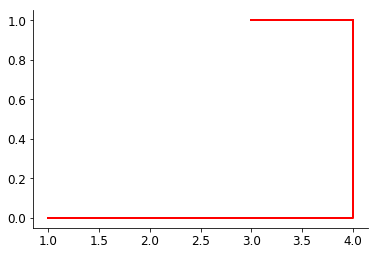

2


In [6]:
a=get_traj(8)
print(a)
plt.plot(
        a[:,0], a[:,1],
        color="red",
        lw=2,
        label="2_D Random walk"
        )
plt.show()
print(count_self_intersections(a))

## Generating the initial condition
You might have noticed that the pivot algorithm requires an element of SAW($n$) as starting condition, to then generate a Markov chain easily. But how do you get this first element? We will use the following strategy:
1. Generate a standard 2D random walk, and count the number of self intersections.
2. Apply the pivot transformation to get a new 2D random walk, and count the number of self-intersections-
3. If the number of self-intersections has decreased or not changed, keep the new path. Else, keep the old one.
4. Go to 2, till the number of self-intersections is 0.

### Exercise
Write a function `get_first_SAW` that generates a SAW of given length

In [7]:
def get_first_SAW(length, max_tries=1000000):
    rw = get_traj(length)
    si_ini = count_self_intersections(rw)
    if(si_ini==0): return rw
    for i in range(max_tries):
        test_saw = pivot_traj(rw)
        si_fin = count_self_intersections(test_saw)
        if (si_fin==0): 
            #print("SAW generated in " + str(i) + " itereations")
            return test_saw
        if (si_fin<=si_ini): 
            rw = test_saw
            si_ini = count_self_intersections(rw)
            
    print("Couldn't generate a SAW of length " + str(length))
    

### Exercise
Generate and plot some 2D SAWs of different lengths. Be carefull, raise the length slowly! You can measure how long a cell takes executing using the `%%time` magic at the top of a cell.

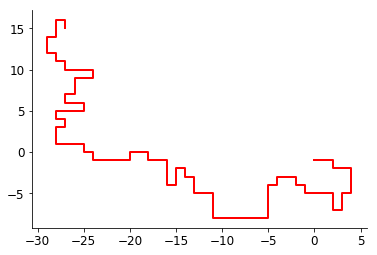

CPU times: user 33.6 s, sys: 62.5 ms, total: 33.7 s
Wall time: 33.9 s


In [8]:
%%time
a = get_first_SAW(100)
plt.plot(
        a[:,0], a[:,1],
        color="red",
        lw=2,
        label="2_D Random walk"
        )
plt.show()

/home/ferra/miniconda3/envs/idp/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


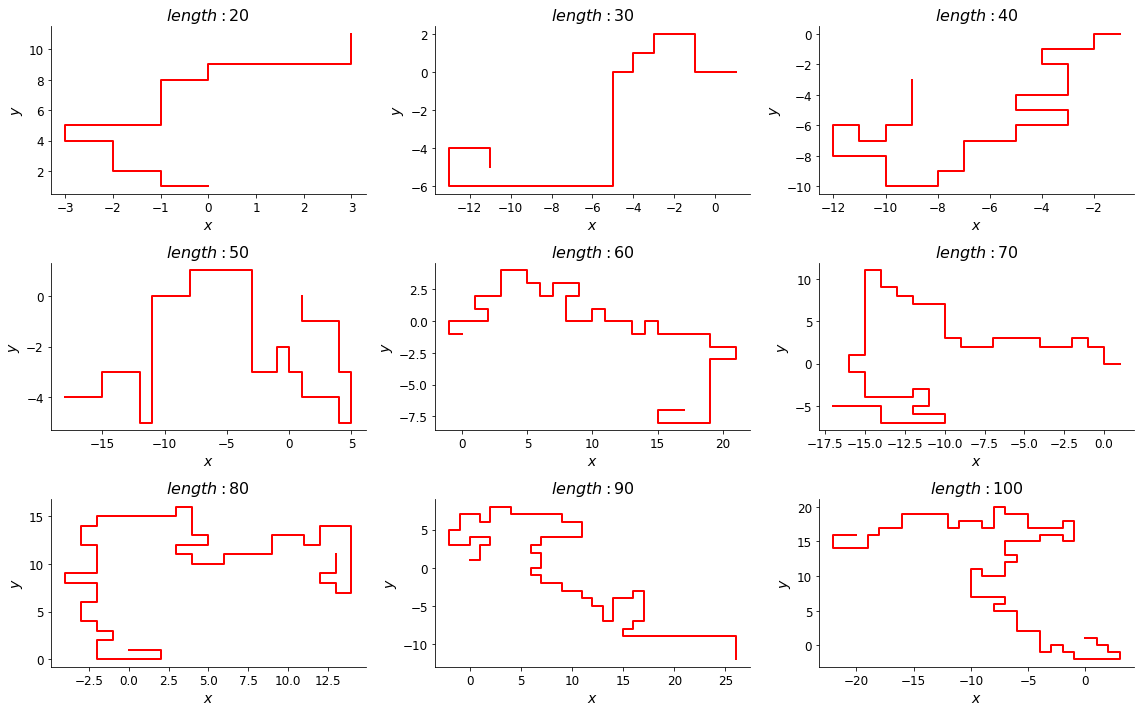

In [9]:
lengths = [20, 30, 40, 50, 60, 70, 80, 90, 100] 
fig, axx = plt.subplots(3, 3, figsize=(16, 10), tight_layout=True)
axx = axx.reshape(-1)
i = 0
for length in lengths:    
    ax = axx[i]
    i = i+1
    a = get_first_SAW(length)
    ax.set_title(f"$length: {length}$")
    ax.plot(
        a[:,0], a[:,1],
        color="red",
        lw=2,
    )
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

### Exercise
Write a function `get_next_SAW` that, given a SAW, generates another SAW using the pivot algorithm. Your function should check that the input RW is really a SAW. Remember the steps:

1. Apply the pivot transformation
2. Check if the new path is self-avoiding. **If so, return it. Otherwise, return the original path.**

In [10]:
def get_next_SAW(traj):
    # make sure input traj is SAW
    assert count_self_intersections(traj) == 0
    
    # pivot step
    proposed_traj = pivot_traj(traj)
    
    # count intersections
    num_intersections = count_self_intersections(proposed_traj)
    
    # if it's a SAW
    if num_intersections==0:
        return proposed_traj
    
    # if not
    else:
        return traj

### Mean Squared Displacement in SAW
A quantity of interest in RWs is the mean squared displacement, which is simply the (squared) distance between the endpoints of the walk. Usually, one writes

$$
\left\langle X(n)^2 \right\rangle \sim n^{2 \nu}
$$

As you know, for a standard RW of $n$ steps, the mean-squared displacement scales like $n$, so $\nu=1/2$. However, the exponent for SAW is **different**! Althought it has not been formally proven (still), it is believed that the exponent for SAW is $\nu=3/4$. That is, for a self-avoiding random walk, the mean squared displacement scales as $n^{3/2}$.

### Exercise
Explain why it makes sense that the mean-squared displacement exponent of SAW is **greater** than that of standard RW. 

*(Answer) The  $\left\langle X(n)^2 \right\rangle $ of a SAW should be greater than that of a standard RW because while a RW with dimensionality <=2 tend to return indefitely at the origin(which is one of the walk endpoints), the SAW by its definition does not, therefore is reasonable to assume that its extrema gets away from the origin faster than a regular RW's one*

### Exercise
Verify numerically the scaling of the mean-squared displacement of SAW. Notice that you don't need to store all the SAWs, just the endpoints. You could follow this scheme:

1. Generate a first SAW with your `get_first_SAW()` function
2. Generate the next SAW using your `get_next_SAW()` function, and store the endpoint.
3. Iterate step 2 for as many steps as required
4. Compute the average mean-squared displacement of the stored endpoints

Then repeating steps 1-4 for different lengths, and plot the results in double-logarithmic axis. Compare your results with the theoretical exponent. Do they agree?

In [11]:
def Check_MSD(length,n_ite):
    endpoints = []
    saw = get_first_SAW(length)
    #print(saw[-1][0])
    endpoints.append(saw[-1])
    r_2 = 0
    for i in range(n_ite):
        saw = get_next_SAW(saw)
        endpoints.append(saw[-1])
        r_2 = r_2 + (endpoints[i][0]**2 + endpoints[i][1]**2)
        #print(endpoints[i])
        #print((endpoints[i][0]**2 + endpoints[i][1]**2))
        #print("-->"+str(r_2))
    r_2 = r_2/n_ite
    return r_2

In [12]:
print(Check_MSD(20,1000))
print(20**(3/2))

62.27
89.44271909999159


In [13]:
lengths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 200]
theory = np.power(lengths,(3/2))
results = []
n_ite = 500
#print(theory)

In [14]:
for length in lengths:
    results.append(Check_MSD(length,n_ite))   

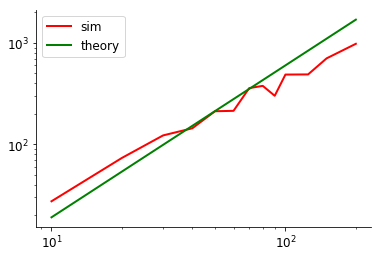

In [23]:
parameter = 0.6
plt.loglog(
        lengths, results,
        color="red",
        lw=2,
        label="sim"
        )
plt.loglog(
        lengths, np.multiply(theory,parameter),
        color="green",
        lw=2,
        label="theory"
        )
plt.legend()
plt.show()